This notebook munges the accuracy and $F_1$ values for the subtype classification task and makes several visualizations.

In [1]:
import getpass
import sys
import time

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal, mannwhitneyu

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams['figure.dpi'] = 200

In [4]:
print(getpass.getuser())

danieldomingo


In [5]:
print(sys.version)

3.6.2 (v3.6.2:5fd33b5926, Jul 16 2017, 20:11:06) 
[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]


In [6]:
print(time.asctime())

Mon May 20 07:16:04 2019


In [7]:
df = pd.read_csv('../../input/subtype_classification_results.tsv', sep='\t')
df = df.sort_values(['Database', 'Dataset'])
df.head()

,Database,Dataset,Metric,Measurement
0,KEGG,BRCA,Accuracy,0.876190
1,KEGG,BRCA,Accuracy,0.914286
2,KEGG,BRCA,Accuracy,0.904762
3,KEGG,BRCA,Accuracy,0.895238
4,KEGG,BRCA,Accuracy,0.847619


In [8]:
accuracy_df = df[df.Metric == 'Accuracy']
del accuracy_df['Metric']
accuracy_df.columns = ['Database', 'Dataset', 'Accuracy']

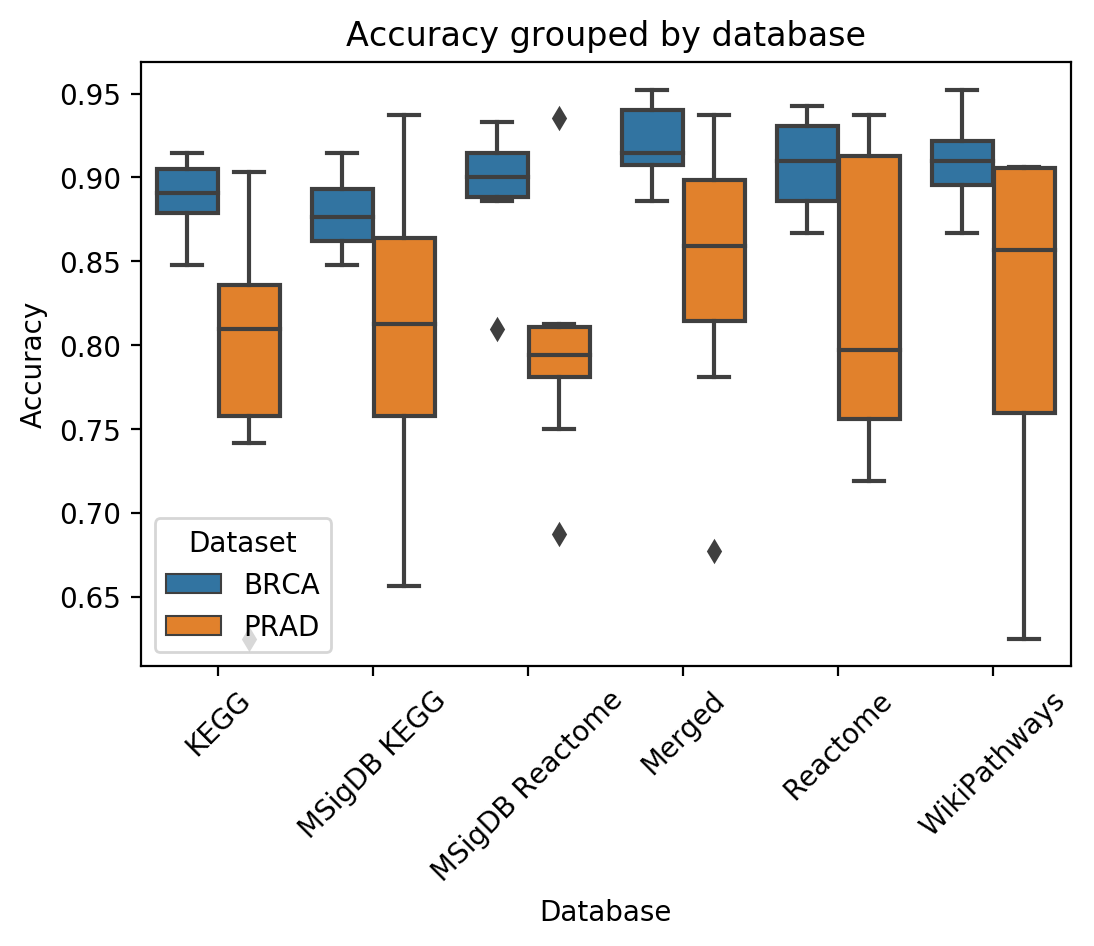

In [9]:
ax = sns.boxplot(
    y='Accuracy',
    x='Database',
    hue='Dataset',
    data=accuracy_df,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.title('Accuracy grouped by database')
plt.show()

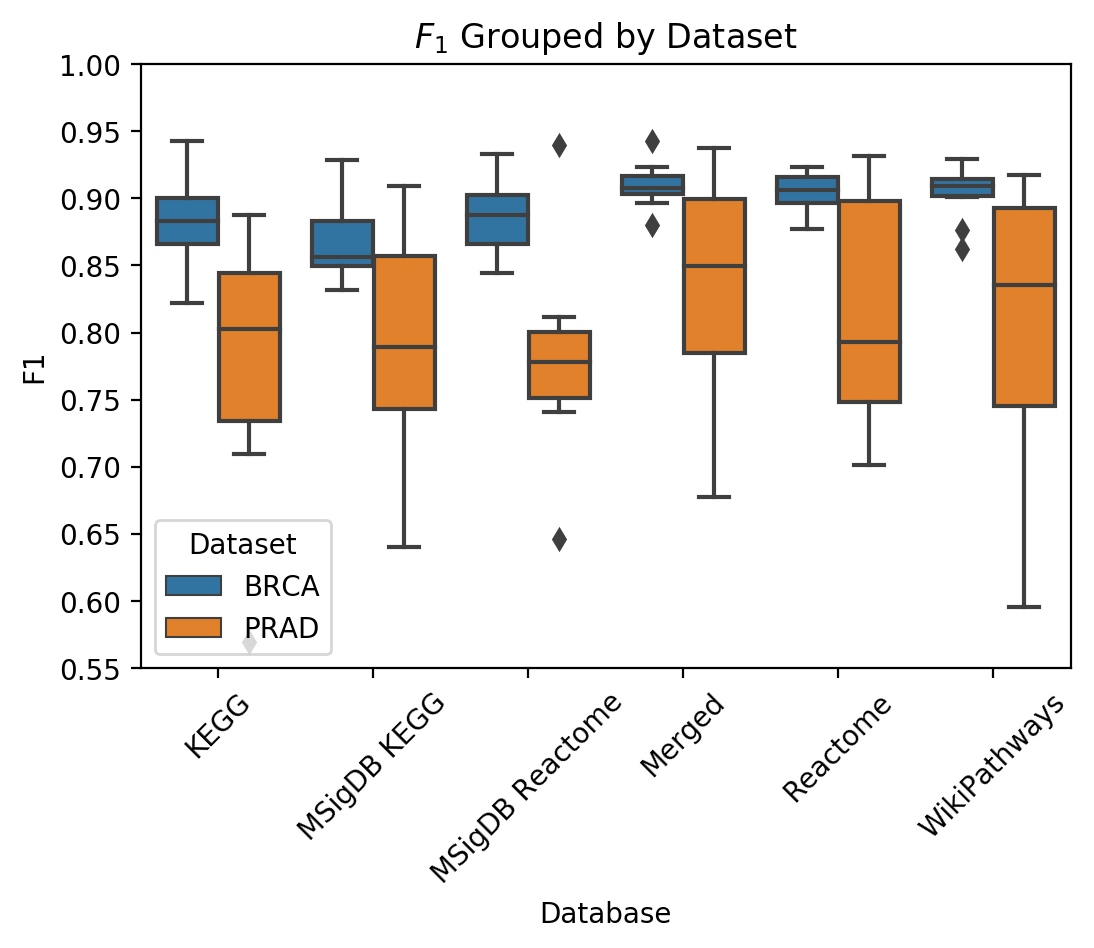

In [10]:
f1_df = df[df.Metric == 'F1']
del f1_df['Metric']
f1_df.columns = ['Database', 'Dataset', 'F1']

ax = sns.boxplot(
    y='F1',
    x='Database',
    hue='Dataset',
    data=f1_df
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylim([0.55,1])
plt.title('$F_1$ Grouped by Dataset')
plt.show()

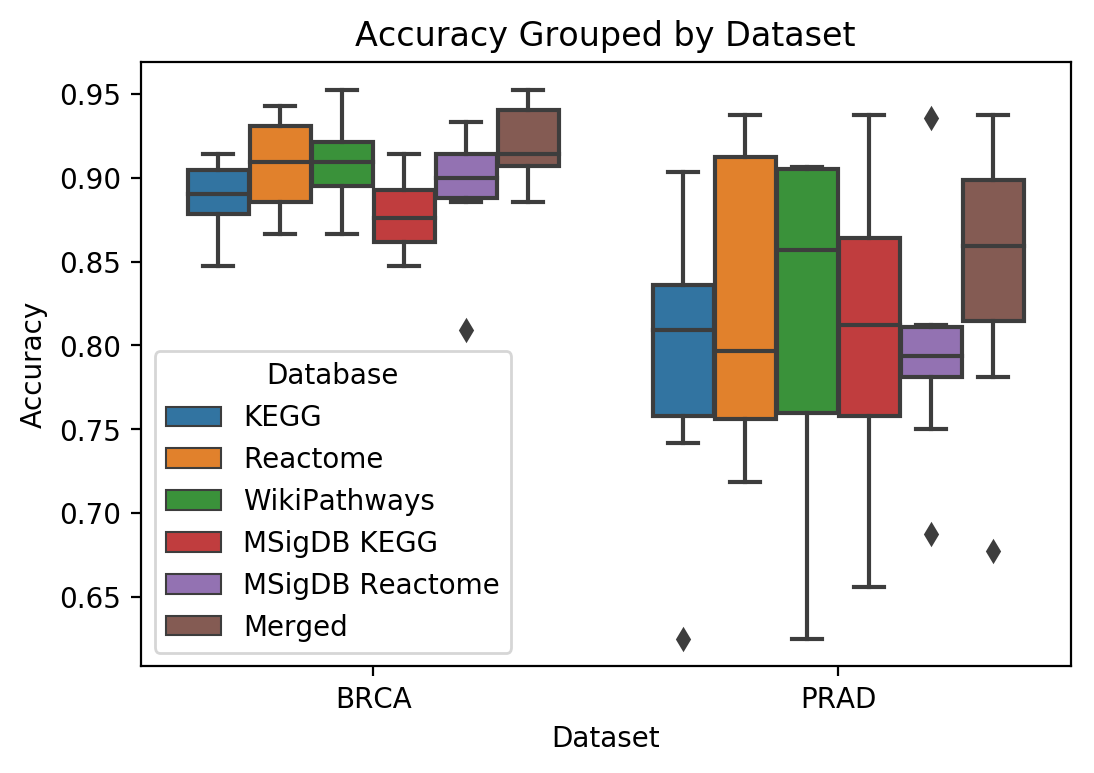

In [11]:
ax = sns.boxplot(
    y='Accuracy',
    x='Dataset',
    hue='Database',
    data=accuracy_df,
    hue_order=['KEGG', 'Reactome', 'WikiPathways', 'MSigDB KEGG', 'MSigDB Reactome', 'Merged'],
)
plt.title('Accuracy Grouped by Dataset')
plt.show()

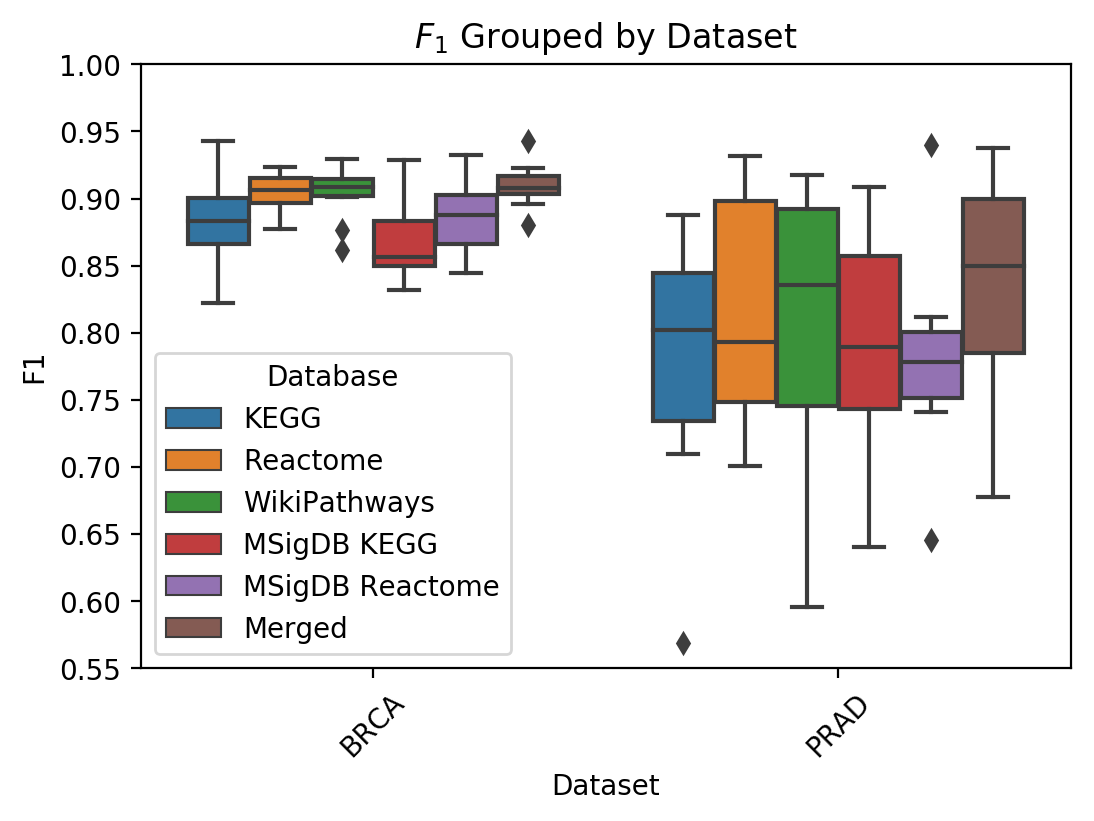

In [12]:
ax = sns.boxplot(
    y='F1',
    x='Dataset',
    hue='Database',
    data=f1_df,
    hue_order=['KEGG', 'Reactome', 'WikiPathways', 'MSigDB KEGG', 'MSigDB Reactome', 'Merged'],
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylim([0.55,1])
plt.title('$F_1$ Grouped by Dataset')
plt.show()

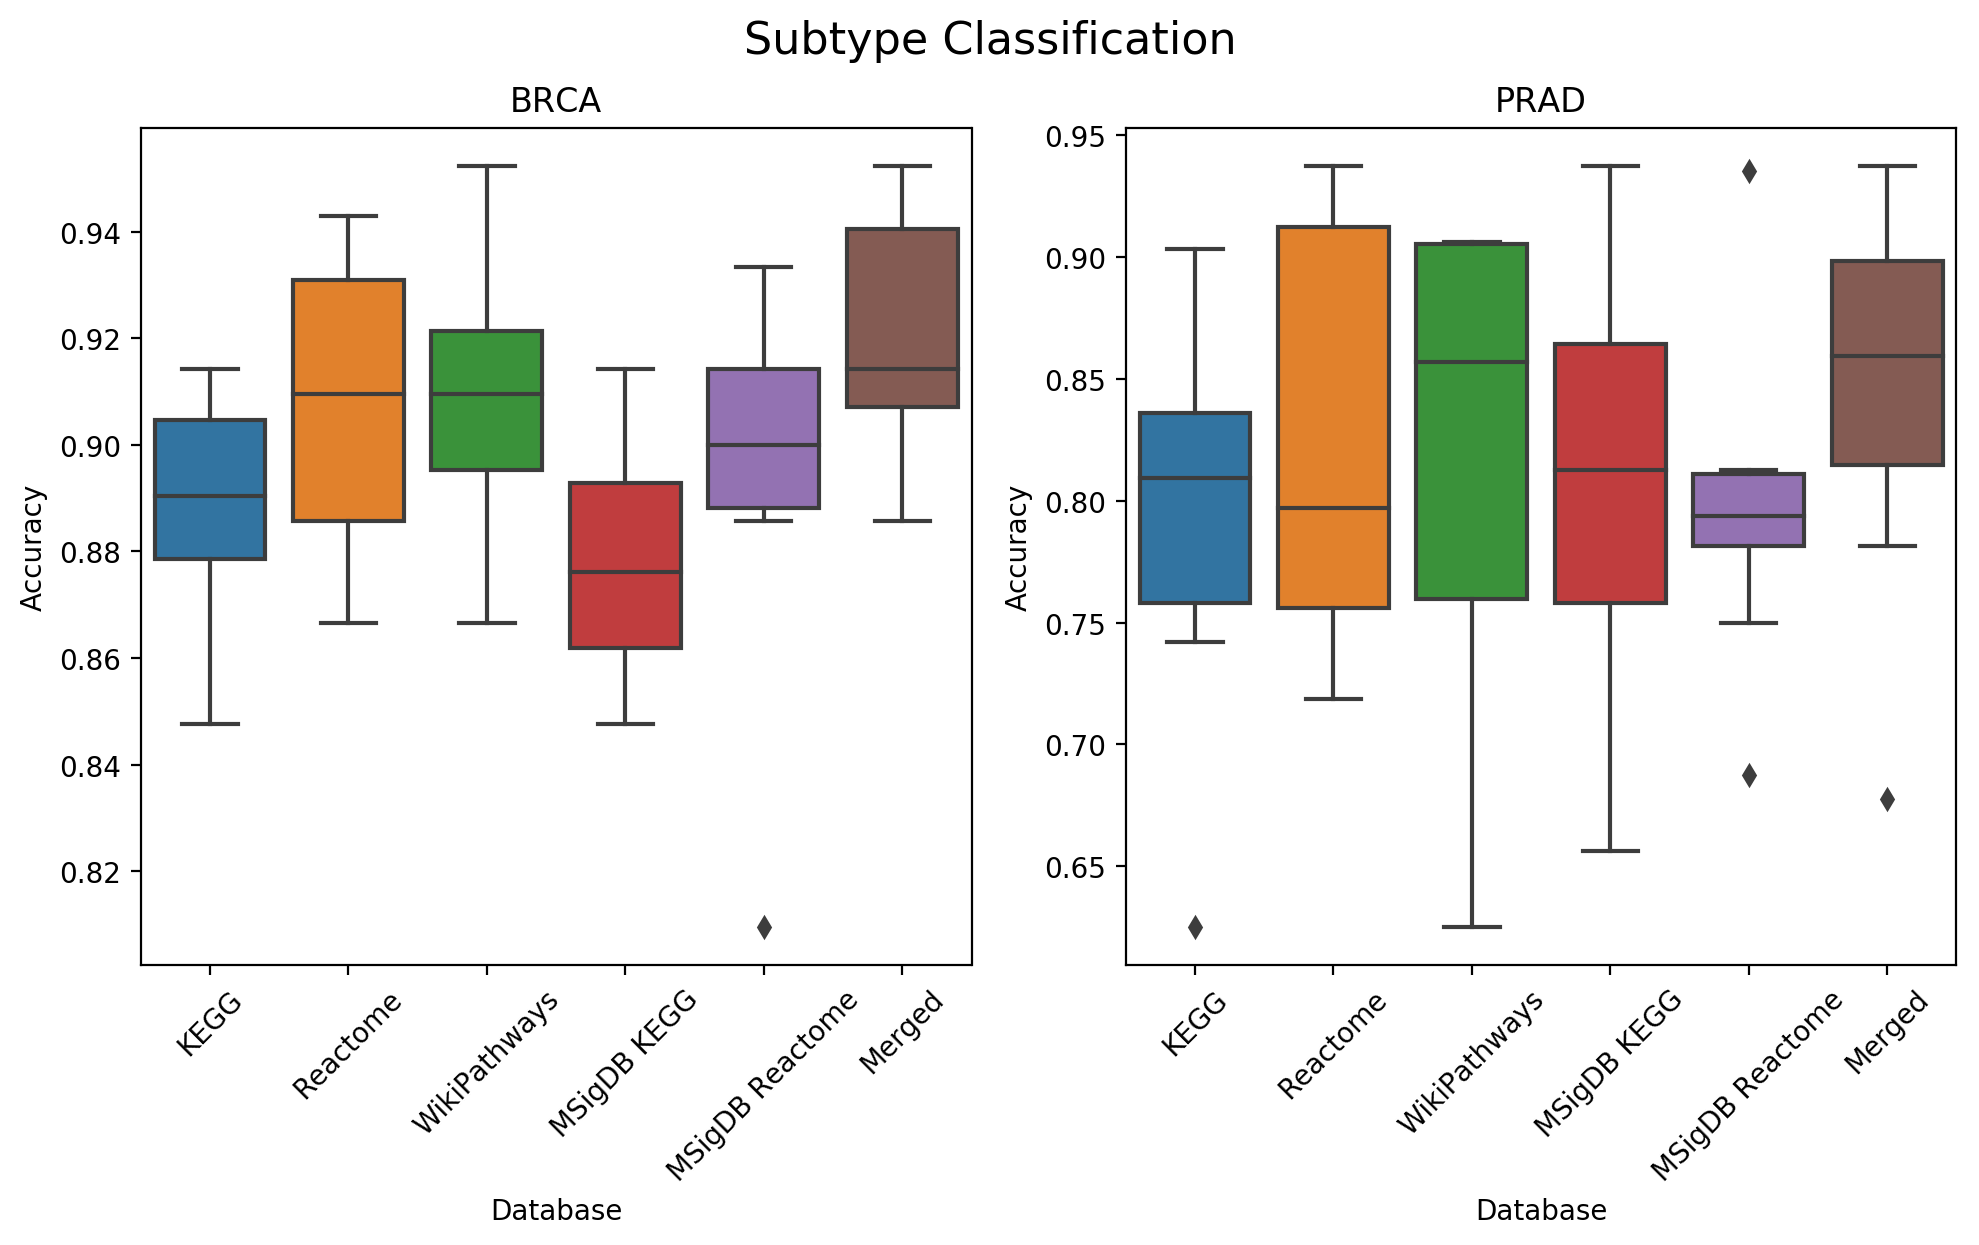

In [13]:
fig = plt.figure(figsize=(10, 6)) 

ax1 = plt.subplot2grid(shape=(1,2), loc=(0,0), colspan=1)
ax2 = plt.subplot2grid((1,2), (0,1), colspan=1)

plt.suptitle('Subtype Classification', fontsize=16, y=1.03)

for dataset, ax in zip(df['Dataset'].unique(), [ax1, ax2]):
    ax.set_title(dataset)
    # Use this to make the y-axes all use the same, but makes readability difficult
    # ax.set_ylim(bottom=y_min, top=1.0)  
    sns.boxplot(
        y='Accuracy',
        x='Database',
        data=accuracy_df[accuracy_df['Dataset'] == dataset],
        order=['KEGG', 'Reactome', 'WikiPathways', 'MSigDB KEGG', 'MSigDB Reactome', 'Merged'],
        ax=ax,
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.savefig('subtype_classification.png',dpi=500)
plt.tight_layout()
plt.show()

## Assessing the significance of the classifiers for BRCA

In [14]:
# Filter dataframe to BRCA and group by database the rows
accuracy_dict = accuracy_df[accuracy_df['Dataset'] == 'BRCA'].groupby('Database')['Accuracy'].apply(list)

stats, p_value = kruskal(
    accuracy_dict['KEGG'],
    accuracy_dict['Reactome'],
    accuracy_dict['WikiPathways'],
    accuracy_dict['Merged'],
    accuracy_dict['MSigDB KEGG'],
    accuracy_dict['MSigDB Reactome'],
)

Assessing whether there are differences across all pathway resources 

In [15]:
p_value

0.013878379935605341

Assessing whether there are differences between the Merge dataset (the most predictive one) and Reactome (the second most predictive one)

In [16]:
stats, p_value = mannwhitneyu(accuracy_dict['Merged'], accuracy_dict['Reactome'])

In [17]:
p_value

0.1350678462330951

Assessing whether there are differences between the Merge dataset (the most predictive one) and KEGG (the fourth most predictive one)

In [18]:
stats, p_value = mannwhitneyu(accuracy_dict['Merged'], accuracy_dict['KEGG'])

In [19]:
p_value

0.005814863332948633

**Note that the *p*-value is even more significant for MSigDB KEGG and MSigDB Reactome. **